In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch import nn

plt.rcParams["figure.figsize"] = (20, 9)

In [ ]:
dataset_address = "../datasets/inertial-measurement-units/"
filename = "leg_extension_concentric_eccentric-000_00B46E19.csv"
df = pd.read_csv(dataset_address+filename, sep=",")
df.head()

In [247]:
filename = "data/leg_flexion_concentric_eccentric-000_00B46E19.csv"
df = pd.read_csv(filename, skiprows=12)
df["Acc_Mag"] = np.linalg.norm(df.loc[:, ["Acc_X", "Acc_Y", "Acc_Z"]], axis=1)
df["FreeAcc_Mag"] = np.linalg.norm(df.loc[:, ["FreeAcc_E", "FreeAcc_N", "FreeAcc_U"]], axis=1)
df["Gyr_Mag"] = np.linalg.norm(df.loc[:, ["Gyr_X", "Gyr_Y", "Gyr_Z"]], axis=1)
df["Mag_Mag"] = np.linalg.norm(df.loc[:, ["Mag_X", "Mag_Y", "Mag_Z"]], axis=1)
df.head()

,PacketCounter,Acc_X,Acc_Y,Acc_Z,FreeAcc_E,FreeAcc_N,FreeAcc_U,Gyr_X,Gyr_Y,Gyr_Z,...,Mat[1][2],Mat[2][2],Mat[3][2],Mat[1][3],Mat[2][3],Mat[3][3],Acc_Mag,FreeAcc_Mag,Gyr_Mag,Mag_Mag
0,47739,-2.231028,-9.159637,-2.516198,-0.038828,-0.008010,-0.055325,-0.018995,0.006425,-0.013430,...,-0.340930,-0.000043,-0.940089,0.702049,0.665048,-0.254634,9.757443,0.068063,0.024134,0.703152
1,47740,-2.181516,-9.199013,-2.556468,-0.022720,-0.069713,-0.019270,-0.009994,0.002696,-0.017198,...,-0.340887,-0.000235,-0.940104,0.702032,0.665030,-0.254727,9.793691,0.075812,0.020073,0.704772
2,47741,-2.173545,-9.167678,-2.520285,-0.004010,-0.049807,-0.059741,0.000637,0.003600,-0.024011,...,-0.340732,-0.000410,-0.940160,0.702057,0.665003,-0.254729,9.753074,0.077883,0.024288,0.703432
3,47742,-2.153349,-9.138593,-2.451214,0.045604,-0.017384,-0.109241,0.002326,0.000296,-0.022296,...,-0.340577,-0.000564,-0.940216,0.702066,0.665000,-0.254710,9.703569,0.119648,0.022419,0.711651
4,47743,-2.153895,-9.155078,-2.469278,0.036250,-0.027337,-0.089006,0.004057,0.001151,-0.030801,...,-0.340356,-0.000767,-0.940296,0.702087,0.664992,-0.254675,9.723788,0.099917,0.031088,0.703560


In [248]:
cols_X = ["Acc_X", "Acc_Y", "Acc_Z"] + ["FreeAcc_E", "FreeAcc_N", "FreeAcc_U"] + ["Gyr_X", "Gyr_Y", "Gyr_Z"] + ["Mag_X", "Mag_Y", "Mag_Z"]
cols_y = ["Acc_Mag", "FreeAcc_Mag", "Gyr_Mag", "Mag_Mag"]
data_X = df.loc[:, cols_X].values
data_y = df.loc[:, cols_y].values

In [249]:
# specify sizes of the partitions
# order is train, devset, test
partitions = [.7, .2, .1]

# split the data (note the third input, and the TMP in the variable name)
train_data, testdev_data, train_labels, testdev_label = train_test_split(data_X, data_y, train_size=partitions[0])

# now split the testdev_data
split = partitions[1] / np.sum(partitions[1:])
devset_data, test_data, devset_labels, test_labels = train_test_split(testdev_data, testdev_label, train_size=split)


In [250]:
def create_model(n_input=1, n_output=1, lr=.01):
    model = nn.Sequential(
        nn.Linear(n_input, n_input*5),
        nn.ReLU(),
        nn.Linear(n_input*5, n_input*10),
        nn.ReLU(),
        nn.Linear(n_input*10, n_input*5),
        nn.ReLU(), 
        nn.Linear(n_input*5, n_output)
    )

    # optimizer (the flavor of gradient descent to implement)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return model, optimizer

def train_model(X, y, model=None, loss_func=nn.MSELoss(), optimizer=None, n_epochs=1, plot_loss=False):
    # train the model
    losses = torch.zeros(n_epochs)
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    ## Train the model!
    for i in range(n_epochs):

        # forward pass
        yHat = model(X)

        # compute loss
        loss = loss_func(yHat, y)
        losses[i] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot(losses.detach())
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show();
    return losses

def evaluate_model(X, y, model):
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    # manually compute losses
    # final forward pass
    predictions = model(X)

    # final loss (MSE)
    test_loss = (predictions-y).pow(2).mean()
    # correlation between the predictions and the ground truth
    r = np.corrcoef(y.T, predictions.detach().T)
    r_mean = np.mean(r[np.triu_indices(r.shape[1], k=1)])

    COLORS = "bgrmykc"
    legends = []
    if y.ndim == 2:
        for feature_i in range(y.shape[1]):
            for sample_i in range(y.shape[0]):            
                # plt.plot(y, "bo", label="Real data")
                # plt.plot(predictions.detach(), "rs", label="Predictions")
                # plt.plot(len(X), test_loss.detach(), "ro")
                plt.scatter(sample_i, y[sample_i, feature_i], color=COLORS[feature_i], alpha=.5, linewidths=.5)
                plt.scatter(sample_i, predictions.detach()[sample_i, feature_i], color=COLORS[feature_i], alpha=.5, linewidths=1, marker="x")
            # legends.append(f"Feature ({feature_i+1})")
        plt.xlabel("Samples")
        plt.ylabel("Values")
        plt.title(f"prediction-data r={r_mean:.2f}\nFinal loss = {test_loss.item():.4f}")
        # plt.legend()
        plt.show()
    else:
        print(f"The data has ndim: {y.ndim}, so it is not possible to plot the results.")
    
    return test_loss, r, r_mean, predictions

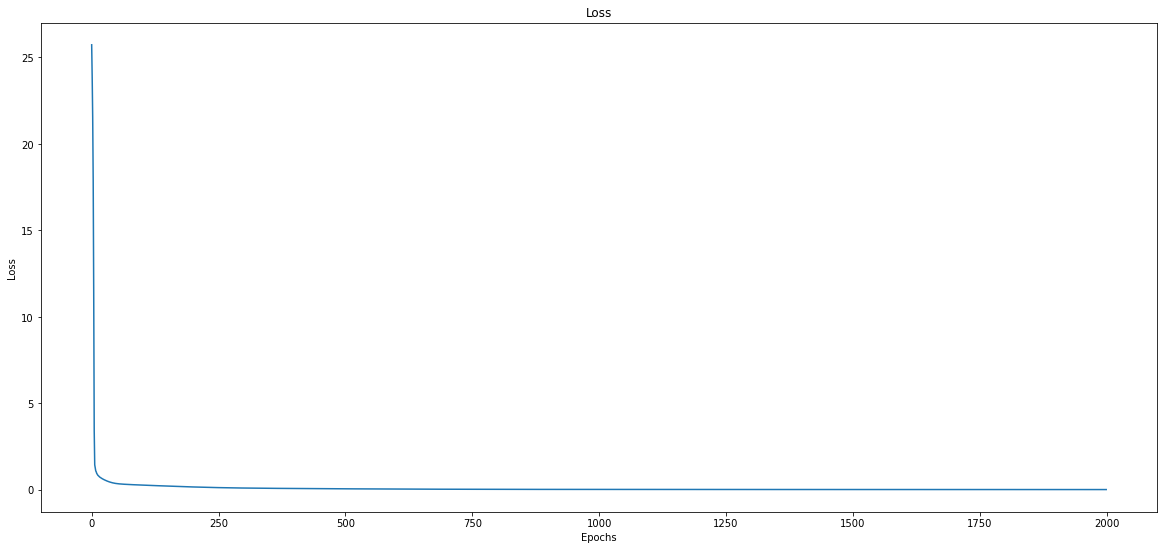

In [251]:
model, optimizer = create_model(n_input=len(cols_X), n_output=len(cols_y), lr=.01)
history = train_model(X=train_data, y=train_labels, model=model, loss_func=nn.MSELoss(), optimizer=optimizer, n_epochs=2000, plot_loss=True)

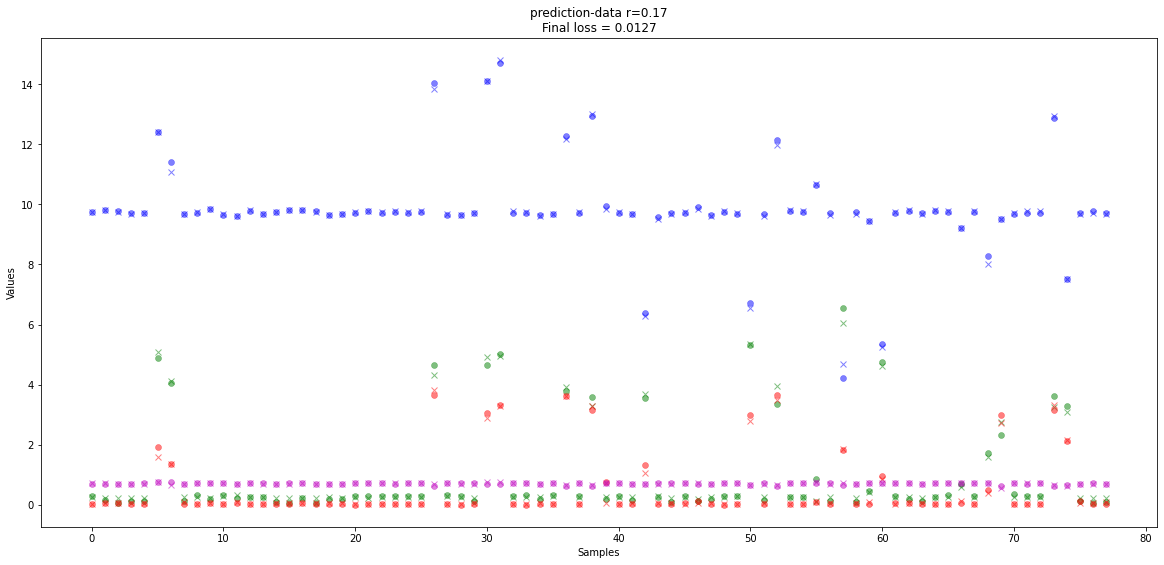

Test Loss: 0.0127
Correlation between predictions and the ground truth: 0.1691


In [252]:
test_loss, r, r_mean, preds = evaluate_model(X=test_data, y=test_labels, model=model)
print(f"Test Loss: {test_loss:.4f}")
print(f"Correlation between predictions and the ground truth: {r_mean:.4f}")